Total Union Area: 110.53
Target Area per Cluster: 18.42
Cluster 2 Union Area: 20.85
Cluster 0 Union Area: 19.67
Cluster 3 Union Area: 21.01
Cluster 5 Union Area: 20.66
Cluster 4 Union Area: 8.99
Cluster 1 Union Area: 19.34
           x          y     score  cluster_label  overlap_area
0  37.454012   3.142919  0.642032              2           0.0
1  95.071431  63.641041  0.084140              0           0.0
2  73.199394  31.435598  0.161629              0           0.0
3  59.865848  50.857069  0.898554              3           0.0
4  15.601864  90.756647  0.606429              5           0.0


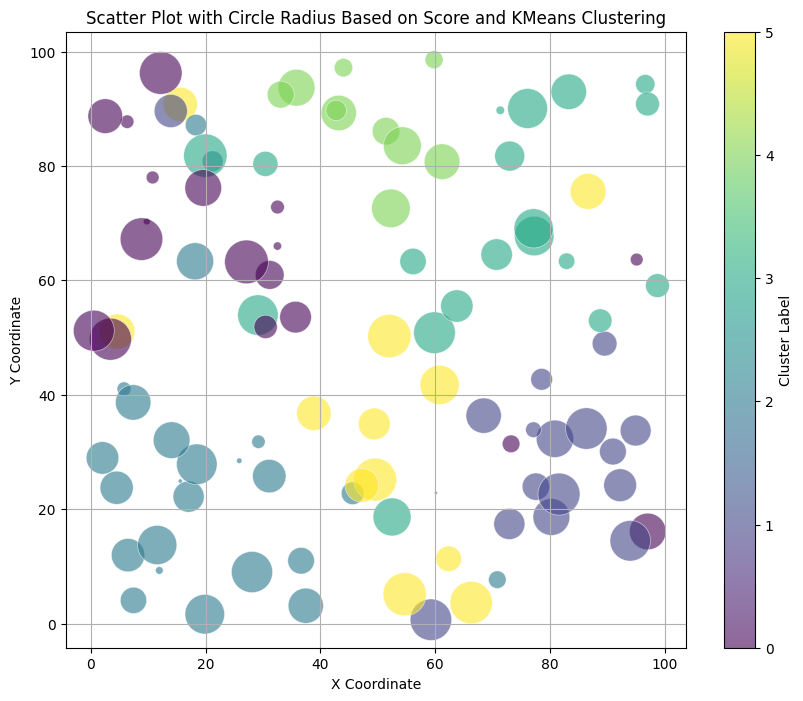

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union

# 設置隨機種子以便重現結果
np.random.seed(42)

# 生成數據的數量
num_samples = 100

# 生成 x 和 y 座標
x_coords = np.random.uniform(low=0.0, high=100.0, size=num_samples)
y_coords = np.random.uniform(low=0.0, high=100.0, size=num_samples)

# 生成 score 值（介於 0 和 1 之間）
scores = np.random.uniform(low=0.0, high=1.0, size=num_samples)

# 將數據組合成 DataFrame
data = pd.DataFrame({
    'x': x_coords,
    'y': y_coords,
    'score': scores
})

# 使用 KMeans 進行聚類
kmeans = KMeans(n_clusters=6, random_state=42)
data['cluster_label'] = kmeans.fit_predict(data[['x', 'y']])

# 計算每個圓的面積
def circle_area(radius):
    return np.pi * radius ** 2

# 計算聯合面積
def calculate_union_area(circles):
    union_polygon = unary_union(circles)
    return union_polygon.area

def calculate_circle_overlap_area(data):
    overlaps = []
    circles = []
    for _, row in data.iterrows():
        circle = Point(row['x'], row['y']).buffer(row['score'])
        circles.append(circle)
    
    for i, circle in enumerate(circles):
        overlap_area = 0
        for j, other_circle in enumerate(circles):
            if i != j:
                overlap_area += circle.intersection(other_circle).area
        overlaps.append(overlap_area)
    
    return overlaps

# 計算總聯合面積
all_circles = [Point(row['x'], row['y']).buffer(row['score']) for _, row in data.iterrows()]
total_union_area = calculate_union_area(all_circles)

# 計算每個群的聯合面積
def get_cluster_union_areas(data):
    cluster_union_areas = {}
    for cluster in data['cluster_label'].unique():
        cluster_data = data[data['cluster_label'] == cluster]
        cluster_circles = [Point(row['x'], row['y']).buffer(row['score']) for _, row in cluster_data.iterrows()]
        cluster_union_areas[cluster] = calculate_union_area(cluster_circles)
    return cluster_union_areas

def balance_clusters(data, max_iterations=100):
    target_area = total_union_area / 6
    cluster_union_areas = get_cluster_union_areas(data)
    
    for _ in range(max_iterations):
        for cluster, area in cluster_union_areas.items():
            if area > target_area:
                # Find nodes with high overlap_area
                nodes = data[data['cluster_label'] == cluster]
                for idx, node in nodes.iterrows():
                    # Create a circle for the node
                    original_circle = Point(node['x'], node['y']).buffer(node['score'])
                    
                    # Evaluate the effect of moving this node to other clusters
                    best_cluster = None
                    best_delta = float('inf')
                    for other_cluster in cluster_union_areas.keys():
                        if other_cluster != cluster:
                            # Move node to this cluster and calculate new union area
                            new_cluster_data = pd.concat([
                                data[data['cluster_label'] == other_cluster],
                                pd.DataFrame([node])
                            ])
                            new_cluster_circles = [Point(row['x'], row['y']).buffer(row['score']) for _, row in new_cluster_data.iterrows()]
                            new_cluster_area = calculate_union_area(new_cluster_circles)
                            
                            delta = abs(new_cluster_area - target_area)
                            if delta < best_delta:
                                best_delta = delta
                                best_cluster = other_cluster
                    
                    if best_cluster is not None:
                        # Move node to best cluster
                        data.loc[idx, 'cluster_label'] = best_cluster
                        break
        cluster_union_areas = get_cluster_union_areas(data)
        # Check if all clusters are within a reasonable range
        if all(abs(area - target_area) < target_area * 0.1 for area in cluster_union_areas.values()):
            break

# 调整簇
balance_clusters(data)

# 計算調整後的聯合面積
cluster_union_areas = get_cluster_union_areas(data)

# 顯示計算結果
print(f'Total Union Area: {total_union_area:.2f}')
print(f'Target Area per Cluster: {total_union_area / 6:.2f}')
for cluster, area in cluster_union_areas.items():
    print(f'Cluster {cluster} Union Area: {area:.2f}')

# 計算每個圓形的重疊面積
data['overlap_area'] = calculate_circle_overlap_area(data)

# 顯示 DataFrame 的前幾行
print(data.head())

# 可視化
plt.figure(figsize=(10, 8))

# 使用 scatter 函數繪製數據點
scatter = plt.scatter(
    data['x'], data['y'],
    s=data['score'] * 1000,  # 圓的半徑，乘以 1000 以放大可見性
    c=data['cluster_label'],  # 顏色根據 cluster_label 區分
    cmap='viridis',  # 使用顏色地圖
    alpha=0.6,  # 使點有一些透明度
    edgecolor='w',  # 點邊緣顏色
    linewidth=0.5  # 點邊緣寬度
)

# 添加顏色條
plt.colorbar(scatter, label='Cluster Label')

# 添加標籤和標題
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot with Circle Radius Based on Score and KMeans Clustering')

# 顯示圖形
plt.grid(True)
plt.show()
